In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [12]:
def read_csvs(filename):

    root_log_path = os.path.join('..', 'cleaned_logs_to_keep', filename)

    log_jobs = pd.read_csv(os.path.join(root_log_path, 'log_jobs.csv'), sep=';', index_col=['Job ID'])
    log_rdds = pd.read_csv(os.path.join(root_log_path, 'log_rdds.csv'), sep=';', index_col=['RDD ID'])
    log_accumulables = pd.read_csv(os.path.join(root_log_path, 'log_accumulables.csv'), sep=';', index_col=['Accumulable ID', 'Task ID'])
    log_stages = pd.read_csv(os.path.join(root_log_path, 'log_stages.csv'), sep=';', index_col=['Stage ID'])
    log_tasks = pd.read_csv(os.path.join(root_log_path, 'log_tasks.csv'), sep=';', index_col=['Task ID'])
    
    return log_jobs, log_stages, log_tasks, log_rdds, log_accumulables

In [63]:
def plot_jobs_duration(log_jobs, filename, first_job_id=0):
    
    run_sorted = log_jobs.loc[0 + first_job_id:5 + first_job_id]
    run_min = log_jobs.loc[6 + first_job_id:11 + first_job_id]
    run_zip = log_jobs.loc[12 + first_job_id:17 + first_job_id]
    run_sorted.reset_index(inplace=True)
    run_min.reset_index(inplace=True)
    run_zip.reset_index(inplace=True)
    
    total_durations = {
        'sorted': sum(run_sorted['Duration']),
        'min': sum(run_min['Duration']),
        'zip': sum(run_zip['Duration'])
    }
    print(f"filename: {filename}, {total_durations}")
    
    run_sorted_rel = run_sorted.copy()
    run_min_rel = run_min.copy()
    run_zip_rel = run_zip.copy()
    for i in range(len(run_sorted_rel)):
        run_min_rel.loc[i, 'Duration'] /= run_sorted_rel.loc[i, 'Duration']
        run_zip_rel.loc[i, 'Duration'] /= run_sorted_rel.loc[i, 'Duration']
        run_sorted_rel.loc[i, 'Duration'] = 1
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    abs_val_plt = ax[0]
    abs_val_plt.plot(run_sorted[['Duration']], label='sorted')
    abs_val_plt.plot(run_min[['Duration']], label='min')
    abs_val_plt.plot(run_zip[['Duration']], label='zip')
    abs_val_plt.set_title(f"Duration of each iteration per job for 3 alternative algorithms for file {filename}")
    abs_val_plt.set_xlabel("Iteration")
    abs_val_plt.set_ylabel("Duration (s)")
    abs_val_plt.legend()
    
    rel_val_plt = ax[1]
    rel_val_plt.plot(run_sorted_rel[['Duration']], label='sorted')
    rel_val_plt.plot(run_min_rel[['Duration']], label='min')
    rel_val_plt.plot(run_zip_rel[['Duration']], label='zip')
    rel_val_plt.set_title(f"Duration of each iteration per job for 3 alternative algorithms for file {filename}")
    rel_val_plt.set_xlabel("Iteration")
    rel_val_plt.set_ylabel("Duration (s)")
    rel_val_plt.legend()   
    
    plt.show()

In [64]:
def plot_stages_duration(log_stages, filename, first_job_id=0):
    
    run_sorted = log_stages.loc[(log_stages['Job ID'] <= 5 + first_job_id)]
    run_min = log_stages.loc[((log_stages['Job ID'] > 5 + first_job_id) & (log_stages['Job ID'] <= 11 + first_job_id))]
    run_zip = log_stages.loc[(log_stages['Job ID'] > 11 + first_job_id)]
    
    run_sorted.reset_index(inplace=True)
    run_min.reset_index(inplace=True)
    run_zip.reset_index(inplace=True)
    
    run_sorted_rel = run_sorted.copy()
    run_min_rel = run_min.copy()
    run_zip_rel = run_zip.copy()
    for i in range(len(run_sorted_rel)):
        run_min_rel.loc[i, 'Duration'] /= run_sorted_rel.loc[i, 'Duration']
        run_zip_rel.loc[i, 'Duration'] /= run_sorted_rel.loc[i, 'Duration']
        run_sorted_rel.loc[i, 'Duration'] = 1
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    abs_val_plt = ax[0]
    abs_val_plt.plot(run_sorted[['Duration']], label='sorted')
    abs_val_plt.plot(run_min[['Duration']], label='min')
    abs_val_plt.plot(run_zip[['Duration']], label='zip')
    abs_val_plt.set_title(f"Duration of each iteration per job for 3 alternative algorithms for file {filename}")
    abs_val_plt.set_xlabel("Iteration")
    abs_val_plt.set_ylabel("Duration (s)")
    abs_val_plt.legend()
    
    rel_val_plt = ax[1]
    rel_val_plt.plot(run_sorted_rel[['Duration']], label='sorted')
    rel_val_plt.plot(run_min_rel[['Duration']], label='min')
    rel_val_plt.plot(run_zip_rel[['Duration']], label='zip')
    rel_val_plt.set_title(f"Duration of each iteration per stage for 3 alternative algorithms for file {filename}")
    rel_val_plt.set_xlabel("Iteration")
    rel_val_plt.set_ylabel("Duration (s)")
    rel_val_plt.legend()   
    
    plt.show()

In [73]:
def plot_tasks_duration(log_stages, log_tasks, filename, first_job_id=0):
    
    run_sorted_stages = log_stages.loc[(log_stages['Job ID'] <= 5 + first_job_id)]
    run_min_stages = log_stages.loc[((log_stages['Job ID'] > 5 + first_job_id) & (log_stages['Job ID'] <= 11 + first_job_id))]
    run_zip_stages = log_stages.loc[(log_stages['Job ID'] > 11 + first_job_id)]
    
    run_sorted_tasks = log_tasks.loc[(log_tasks['Stage ID'].isin(run_sorted_stages.index.values))]
    run_min_tasks = log_tasks.loc[(log_tasks['Stage ID'].isin(run_min_stages.index.values))]
    run_zip_tasks = log_tasks.loc[(log_tasks['Stage ID'].isin(run_zip_stages.index.values))]
    
    run_sorted_tasks.reset_index(inplace=True)
    run_min_tasks.reset_index(inplace=True)
    run_zip_tasks.reset_index(inplace=True)
    
    run_sorted_rel = run_sorted_tasks.copy()
    run_min_rel = run_min_tasks.copy()
    run_zip_rel = run_zip_tasks.copy()
    for i in range(len(run_sorted_rel)):
        run_min_rel.loc[i, 'Duration'] /= run_sorted_rel.loc[i, 'Duration']
        run_zip_rel.loc[i, 'Duration'] /= run_sorted_rel.loc[i, 'Duration']
        run_sorted_rel.loc[i, 'Duration'] = 1
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    abs_val_plt = ax[0]
    abs_val_plt.plot(run_sorted_tasks[['Duration']], label='sorted')
    abs_val_plt.plot(run_min_tasks[['Duration']], label='min')
    abs_val_plt.plot(run_zip_tasks[['Duration']], label='zip')
    abs_val_plt.set_title(f"Duration of each iteration per job for 3 alternative algorithms for file {filename}")
    abs_val_plt.set_xlabel("Iteration")
    abs_val_plt.set_ylabel("Duration (s)")
    abs_val_plt.legend()
    
    rel_val_plt = ax[1]
    rel_val_plt.plot(run_sorted_rel[['Duration']], label='sorted')
    rel_val_plt.plot(run_min_rel[['Duration']], label='min')
    rel_val_plt.plot(run_zip_rel[['Duration']], label='zip')
    rel_val_plt.set_title(f"Duration of each iteration per stage for 3 alternative algorithms for file {filename}")
    rel_val_plt.set_xlabel("Iteration")
    rel_val_plt.set_ylabel("Duration (s)")
    rel_val_plt.legend()   
    
    plt.show()

In [74]:
filenames = ['graph_5M.txt', 'graph_15M.txt']

filename: graph_5M.txt, {'sorted': 117.78499999999998, 'min': 108.76599999999999, 'zip': 106.537}


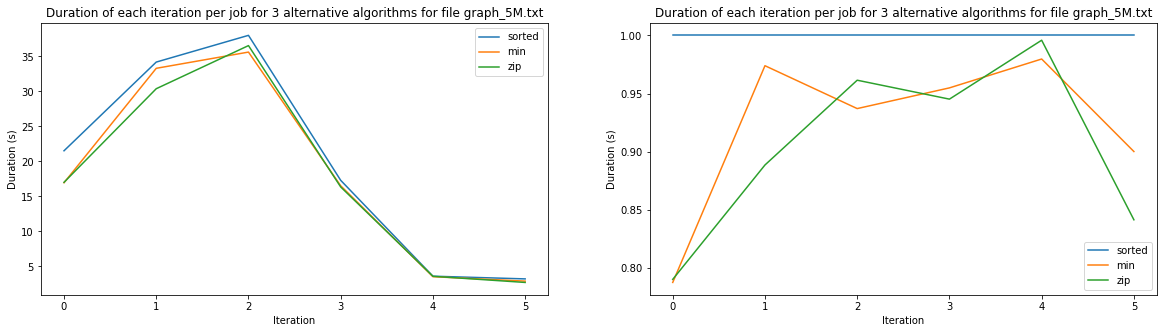

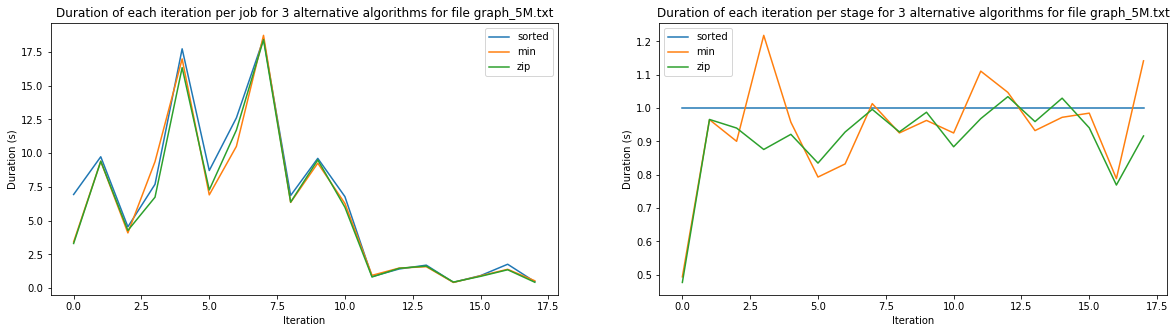

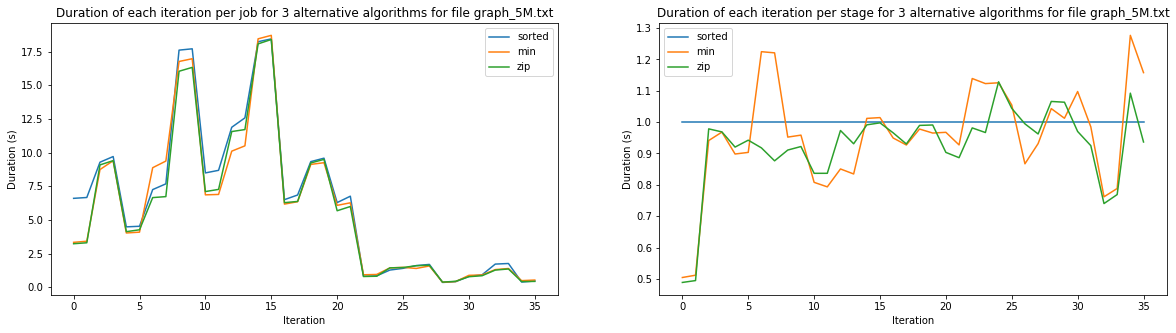

filename: graph_15M.txt, {'sorted': 694.973, 'min': 671.8389999999999, 'zip': 673.4810000000001}


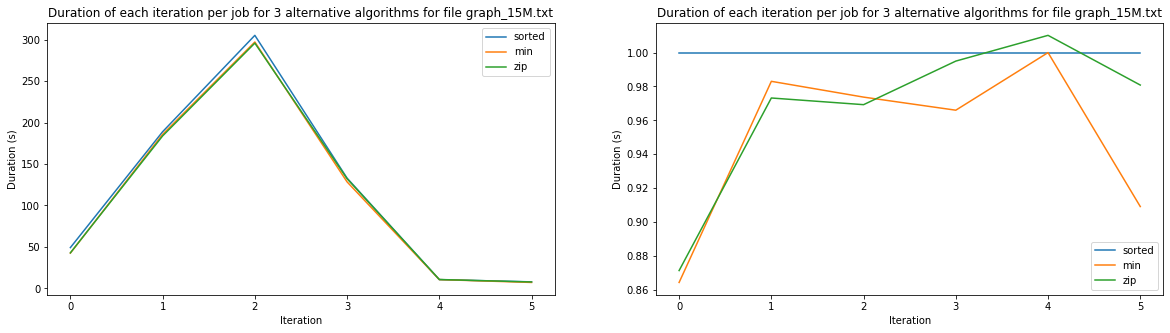

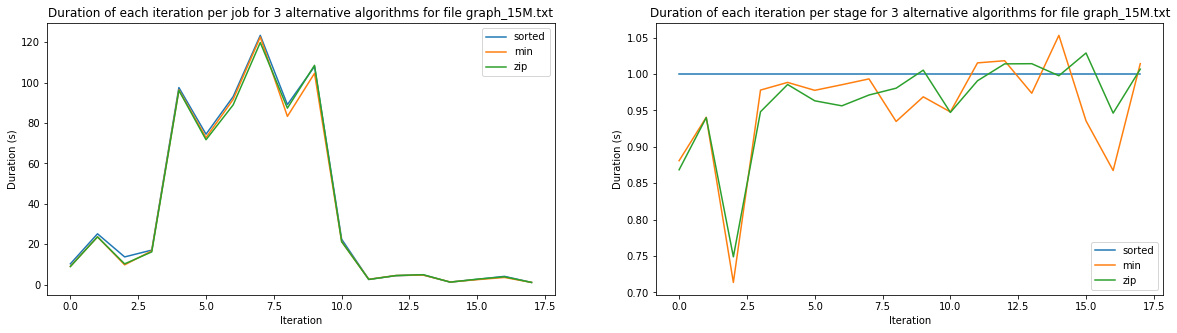

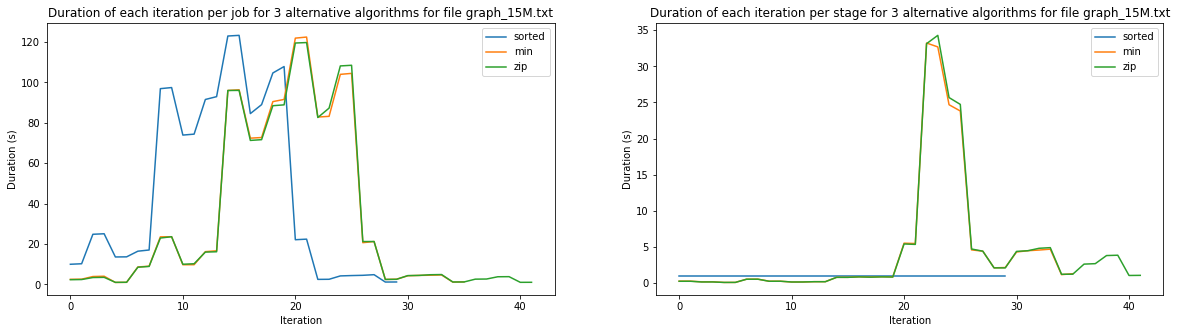

In [75]:
log_jobs, log_stages, log_tasks, log_rdds, log_accumulables = read_csvs('graph_5M.txt')
plot_jobs_duration(log_jobs, 'graph_5M.txt', first_job_id=0)
plot_stages_duration(log_stages, 'graph_5M.txt', first_job_id=0)
plot_tasks_duration(log_stages, log_tasks, 'graph_5M.txt', first_job_id=0)

log_jobs, log_stages, log_tasks, log_rdds, log_accumulables = read_csvs('graph_15M.txt')
plot_jobs_duration(log_jobs, 'graph_15M.txt', first_job_id=1)
plot_stages_duration(log_stages, 'graph_15M.txt', first_job_id=1)
plot_tasks_duration(log_stages, log_tasks, 'graph_15M.txt', first_job_id=0)

In [ ]:
log_stages